In [1]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [207]:
import pandas as pd

df = pd.read_csv('../output/square@okhttp/baseline/okhttp@untreated.csv')
df.head()

,travisBuildNumber,travisBuildId,travisJobId,testName,index,duration,count,failures,errors,skipped
0,1,2685383,2685384,libcore.net.http.HttpResponseCacheTest,0,2.796,100,0,1,0
1,1,2685383,2685384,libcore.net.http.RawHeadersTest,1,0.001,2,0,0,0
2,1,2685383,2685384,libcore.net.http.URLConnectionTest,2,5.621,110,0,0,0
3,1,2685383,2685384,libcore.net.http.NewURLConnectionTest,3,0.000,1,0,0,0
4,1,2685383,2685384,libcore.net.spdy.SpdyConnectionTest,4,0.218,11,0,0,0


In [208]:
builds = df[(df['failures'] > 0) | (df['errors'] > 0)].groupby('travisBuildNumber').agg({
    'testName': list,
    'travisJobId': list,
})
builds.head()

,testName,travisJobId
travisBuildNumber,,
1,[libcore.net.http.HttpResponseCacheTest],[2685384]
2,"[libcore.net.http.HttpResponseCacheTest, libco...","[2697352, 2697352]"
3,[libcore.net.http.HttpResponseCacheTest],[2820645]
4,[libcore.net.http.HttpResponseCacheTest],[2923196]
5,[libcore.net.http.HttpResponseCacheTest],[2923220]


In [209]:
import numpy as np

def failure_distance():
    """For every build, determine how many builds the current failures are in the past.
    
    For example:
     - in build X, test T failed. Last time, T failed 5 builds ago.
     - in build Y, test U failed, as it just did in the build before.
     
    This allows a finer-grained characterization of "edge changelists". E.g., include
    only edge change lists whose failures are at least 10 builds apart.
    
    Implementation note: we scan the build numbers in descending order from left-to-right.
    Each increment in the index means one further step into the past.
    """

    build_numbers = builds.index.unique().sort_values(ascending=False)
    
    def tests_from_index(index):
        build_number = build_numbers[index]
        return set(builds.loc[build_number]['testName'])
    
    index = 0
    rows = []
    while index < len(build_numbers):
        red_tests = tests_from_index(index)
        prior_index = index + 1
        distance = {}
        
        while prior_index < len(builds):
            
            for test in tests_from_index(prior_index):
                if test in red_tests:
                    distance[test] =  prior_index - index
                    red_tests.remove(test)
            
            if not red_tests:
                break
            prior_index += 1
        
        for test in red_tests:
            distance[test] = np.nan
        rows.append((build_numbers[index], np.mean(list(distance.values()))))
        index += 1
    
    return pd.DataFrame(rows, columns=['travisBuildNumber', 'distance'])

distances = failure_distance()
distances.head()

,travisBuildNumber,distance
0,6872,1.0
1,6829,1.0
2,6748,5.0
3,6606,1.0
4,6550,1.5


In [210]:
builds.tail(15)

,testName,travisJobId
travisBuildNumber,,
6215,[okhttp3.internal.framed.Spdy3ConnectionTest],[111910569]
6224,[com.squareup.okhttp.internal.framed.Spdy3Conn...,[112033926]
6291,[okhttp3.mockwebserver.MockWebServerTest],[119049204]
6349,[okhttp3.ConnectionReuseTest],[124973144]
6385,[okhttp3.URLConnectionTest],[128577751]
6394,[okhttp3.CallTest],[128658868]
6407,[okhttp3.CallTest],[129887018]
6416,[okhttp3.CallTest],[130255203]
6457,[okhttp3.internal.framed.Spdy3ConnectionTest],[133597207]


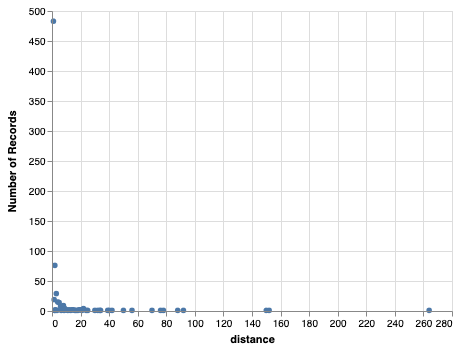

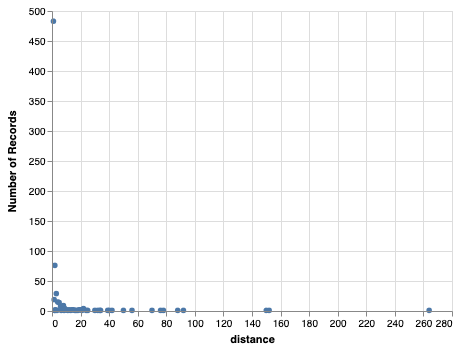

In [211]:
import altair as alt
alt.Chart(distances).mark_point(filled=True).encode(
  x=alt.X('distance'),
  y='count(distance)')


In [212]:
apfd = pd.read_csv('../output/square@okhttp/baseline-evaluation/square@okhttp-apfd.csv')
apfd.head()

,travisJobId,matrix-path-similarity,matrix-naive,matrix-tc-similarity,path-tc-overlap,bloom,lru,matrix-conditional-prob,optimal-failure,matrix-file-similarity,optimal-failure-duration,matrix-recently-changed,untreated,random,recently-failed
0,2685384,0.820144,0.820144,0.820144,0.359712,0.820144,0.820144,0.820144,0.820144,0.820144,0.820144,0.820144,0.820144,0.776978,0.820144
1,2697352,0.701510,0.701510,0.701510,0.478513,0.701510,0.383275,0.701510,0.703833,0.701510,0.701510,0.701510,0.701510,0.672474,0.701510
2,2820645,0.825784,0.825784,0.825784,0.825784,0.825784,0.181185,0.825784,0.825784,0.825784,0.825784,0.825784,0.825784,0.198606,0.825784
3,2923196,0.826389,0.826389,0.826389,0.437500,0.826389,0.565972,0.826389,0.826389,0.826389,0.826389,0.826389,0.826389,0.263889,0.826389
4,2923220,0.826389,0.826389,0.826389,0.437500,0.826389,0.569444,0.826389,0.826389,0.826389,0.826389,0.826389,0.826389,0.565972,0.826389


In [213]:
f = pd.merge(left=apfd[['travisJobId', 'matrix-file-similarity', 'recently-failed']],
             right=df[['travisBuildNumber', 'travisJobId']].drop_duplicates(),
             on='travisJobId',
             validate='1:1')

f = f.groupby('travisBuildNumber').agg({
    'matrix-file-similarity': 'median',
    'recently-failed': 'median',
}).reset_index()
f.head()

,travisBuildNumber,matrix-file-similarity,recently-failed
0,1,0.820144,0.820144
1,2,0.701510,0.701510
2,3,0.825784,0.825784
3,4,0.826389,0.826389
4,5,0.826389,0.826389


In [214]:
g = pd.merge(left=distances, right=f, on='travisBuildNumber', validate='1:1')
g.head()

,travisBuildNumber,distance,matrix-file-similarity,recently-failed
0,6872,1.0,0.943430,0.958161
1,6829,1.0,0.610119,0.958333
2,6748,5.0,0.455422,0.957831
3,6606,1.0,0.973137,0.987579
4,6550,1.5,0.861467,0.990687


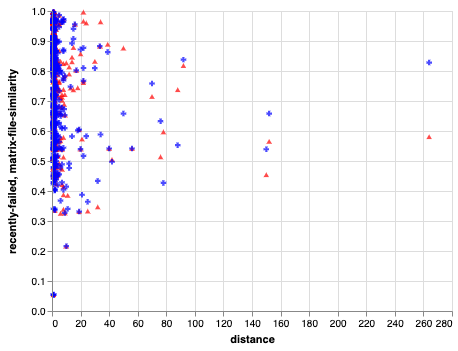

In [336]:
def make_scatter(df, strategy, shape, color):
    return alt.Chart(df).mark_point(filled=True, shape=shape, color=color).encode(
        x=alt.X('distance'),#, scale=alt.Scale(type='log')),
        y=alt.Y(strategy))

alt.layer(
    make_scatter(g, 'recently-failed', 'triangle-up', 'red'),
    make_scatter(g, 'matrix-file-similarity', 'cross', 'blue')
)

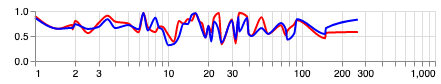

In [327]:
def make_area(df, strategy, color):
    return alt.Chart(df, height=50).mark_line(interpolate='monotone', color=color).encode(
        x=alt.X('distance', title='', scale=alt.Scale(type='log')),
        y=alt.Y('median(%s)' % strategy, title=''))

make_area(g, 'recently-failed', 'red') + make_area(g, 'matrix-file-similarity', 'blue')

In [218]:
h = pd.melt(g, id_vars=['distance'], value_vars=['matrix-file-similarity', 'recently-failed'])
h.head()

,distance,variable,value
0,1.0,matrix-file-similarity,0.943430
1,1.0,matrix-file-similarity,0.610119
2,5.0,matrix-file-similarity,0.455422
3,1.0,matrix-file-similarity,0.973137
4,1.5,matrix-file-similarity,0.861467


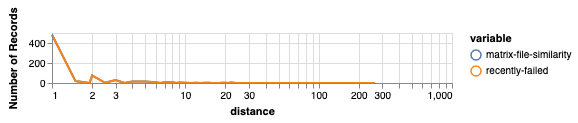

In [334]:
# support
alt.Chart(h, height=50).mark_line().encode(
    x=alt.X('distance', scale=alt.Scale(type='log')),
    y=alt.Y('count()'),
    color='variable')

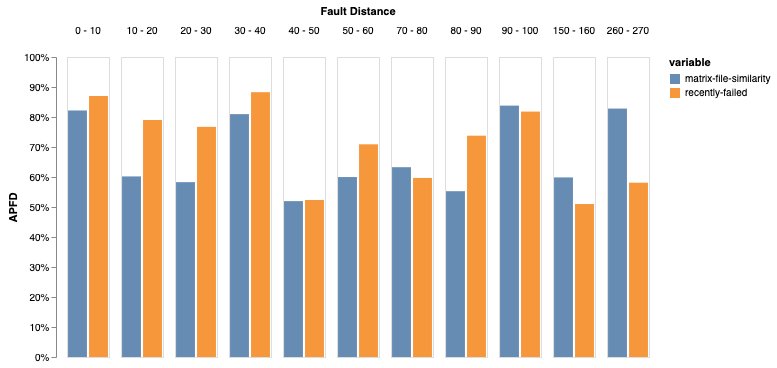

In [324]:
alt.Chart(h).mark_bar(opacity=.85).encode(
    x=alt.X('variable:O', axis=None),
    y=alt.Y('median(value)', scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(format='%', grid=False), title='APFD'),
    color='variable',
    column=alt.Column('distance', bin=alt.BinParams(step=10), title='Fault Distance')
).transform_filter("datum.distance != null")

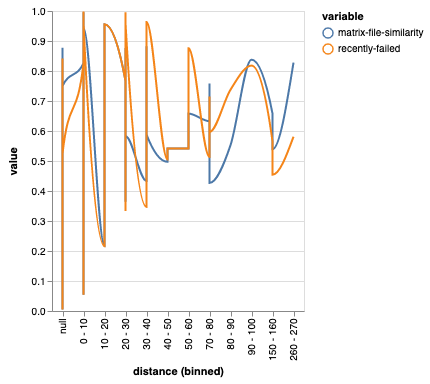

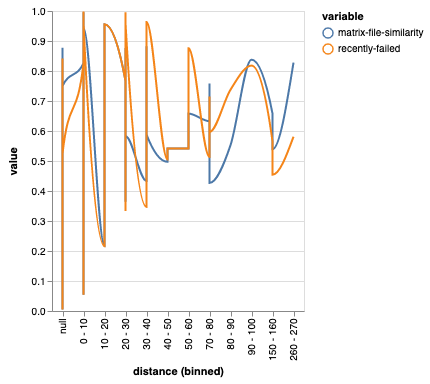

In [304]:
alt.Chart(h).mark_line(interpolate='monotone').encode(
    x=alt.X('distance:O', bin=alt.BinParams(step=10)),
    y=alt.Y('value'),
    color='variable')

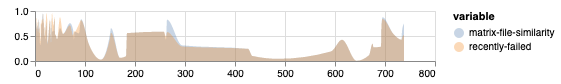

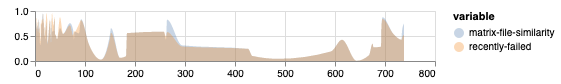

In [186]:
def make_area2(df):
    return alt.Chart(df, height=50).mark_area(interpolate='monotone', opacity=.3).encode(
        x=alt.X('distance', title=''),
        y=alt.Y('median(value)', title='', stack=None),
        color='variable')

make_area2(h)

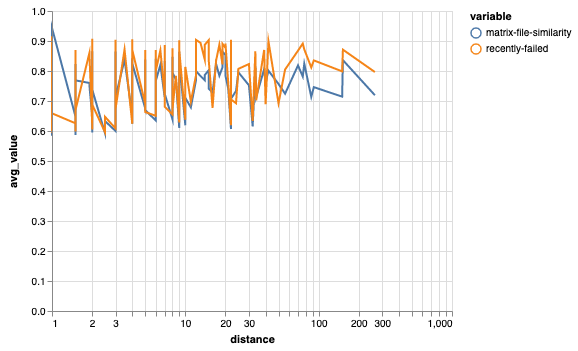

In [329]:
alt.Chart(h).mark_line().encode(
  x=alt.X('distance', scale=alt.Scale(type='log')),
  y=alt.Y('avg_value:Q'),
  color='variable')\
.transform_window(frame=[-100, 0], window=[alt.WindowFieldDef(**{'op': 'mean', 'field': 'value', 'as': 'avg_value'})])

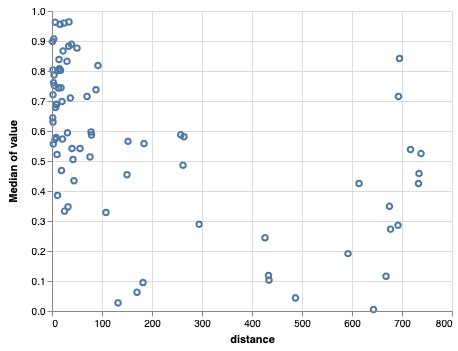

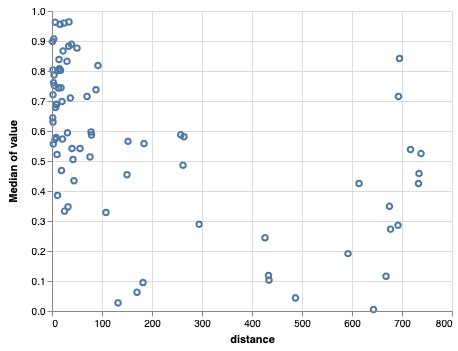

In [163]:
alt.Chart(h).mark_point().encode(
  x=alt.X('distance'),
  y=alt.Y('median(value)')).transform_filter('datum.variable == "recently-failed"')

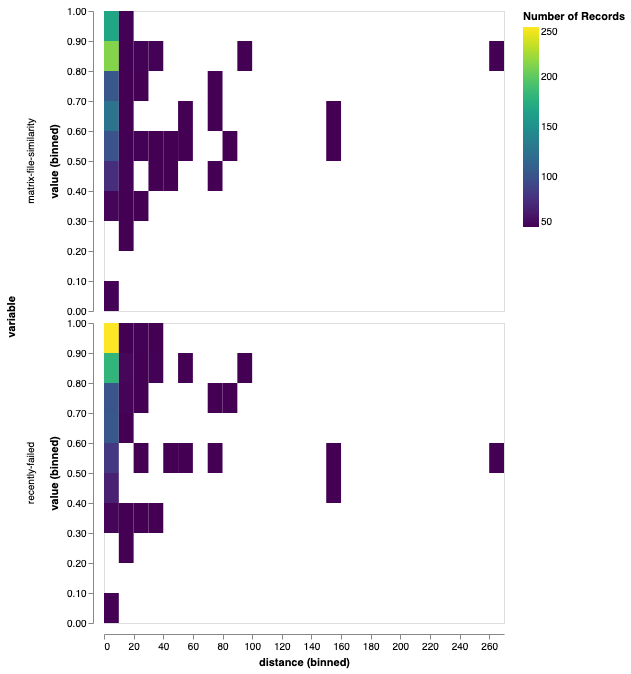

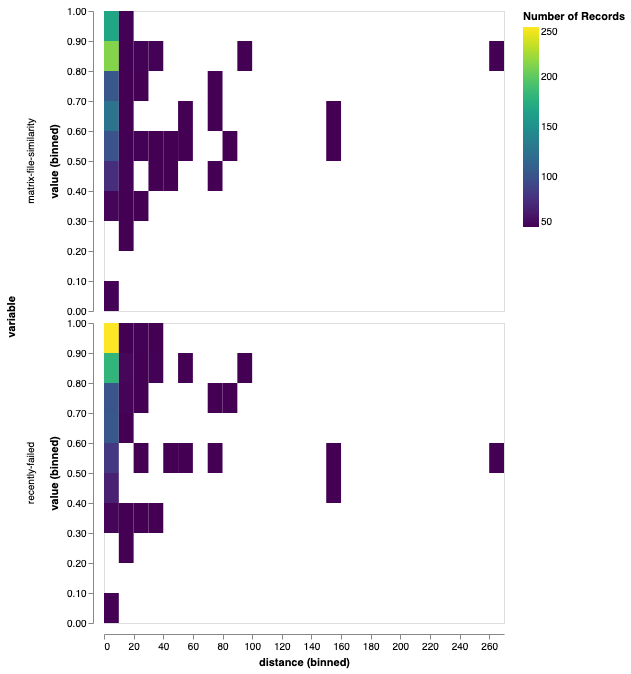

In [306]:
alt.Chart(h) \
.mark_rect().encode(
    x=alt.X('distance', bin=alt.BinParams(step=10)),
    y=alt.Y('value', bin=alt.BinParams(step=.1)),
    color='count()').facet('variable')